In [ ]:
"""
TODO:
- train test split for validating model performance
- logic to do price change directional classification
- mechanism for predicting n timesteps in the future

"""

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import misc_data_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Couldn't find: ZTS PH PAYX PAYC PYPL PENN PNR PBCT TROW
data = misc_data_utils.get_snp_data(size=50, start="1990-01-01")

Using 50 symbols
[*********************100%***********************]  50 of 50 completed


In [7]:
raw_data = data["Adj Close"].pct_change().values[1:]

In [8]:
isnan_bool = np.isnan(raw_data[0])
nan_cols = np.where(isnan_bool)[0]

raw_data_clean = raw_data[:, np.where(1 - isnan_bool)[0]]

In [9]:
nan_data = raw_data[:, nan_cols]
rows, cols = np.where(np.isnan(nan_data))

cleaned_data = []
for i in range(nan_data.shape[1]):
    last_nan_row = np.max(rows[np.where(cols == i)])
    not_nan_data = nan_data[:, i][last_nan_row + 1:]
    if len(not_nan_data):
        cleaned_data.append(not_nan_data)

for i in range(raw_data_clean.shape[1]):
    cleaned_data.append(raw_data_clean[:, i])

In [10]:
np.sum([np.sum(np.isnan(cleaned_data[i])) for i in range(len(cleaned_data))])

# No more nans

0

In [11]:
remove_idxs = []
for i in range(len(cleaned_data)):
    if len(np.where(cleaned_data[i] == 0)[0]) / len(cleaned_data[i]) > .04:
        remove_idxs.append(i)

cleaned_data_ = []
for i in range(len(cleaned_data)):
    if i not in remove_idxs:
        cleaned_data_.append(cleaned_data[i])

In [12]:
lag = 20
inputs = []
outputs = []
for data in cleaned_data:
    inputs.append(np.array([data[i-lag:i] for i in range(lag, len(data))]))
    outputs.append(np.array([data[i] for i in range(lag, len(data))]))

In [13]:
x, y = np.vstack(inputs), np.hstack(outputs)

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [15]:
layers = [
    Dense(64, activation='relu'), 
    Dense(128, activation='relu'), 
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
]

model = Sequential(layers)
model.compile(loss="mse", optimizer="adam")

In [18]:
history = model.fit(x, y, epochs=20, batch_size=1024)

Epoch 1/20
310/310 [==============================] - 2s 6ms/step - loss: 5.9441e-04
Epoch 2/20
310/310 [==============================] - 2s 6ms/step - loss: 5.9082e-04
Epoch 3/20
310/310 [==============================] - 2s 6ms/step - loss: 5.8657e-04
Epoch 4/20
310/310 [==============================] - 2s 6ms/step - loss: 5.8343e-04
Epoch 5/20
310/310 [==============================] - 2s 6ms/step - loss: 5.7991e-04
Epoch 6/20
310/310 [==============================] - 2s 6ms/step - loss: 5.7662e-04
Epoch 7/20
310/310 [==============================] - 2s 6ms/step - loss: 5.7290e-04
Epoch 8/20
310/310 [==============================] - 2s 6ms/step - loss: 5.7002e-04
Epoch 9/20
310/310 [==============================] - 2s 6ms/step - loss: 5.6698e-04
Epoch 10/20
310/310 [==============================] - 2s 6ms/step - loss: 5.6424e-04
Epoch 11/20
310/310 [==============================] - 2s 6ms/step - loss: 5.6178e-04
Epoch 12/20
310/310 [==============================] - 2s 6ms/s

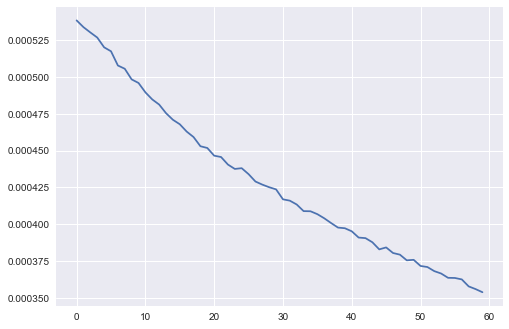

In [62]:
plt.plot(history.history["loss"])